In [1]:
import numpy as np, xarray as xr, matplotlib.pylab as plt, pandas as pd, seaborn as sns
import pickle, random, re, io, regionmask, dask, timeit, os, shutil, datetime
from scipy.signal import welch; from eofs.xarray import Eof; import matplotlib as mpl

from statsmodels.tsa.api import VAR; from contextlib import redirect_stdout
from distributed import Client; from scipy import stats
import cartopy.crs as ccrs, cartopy.feature as cfeature
import matplotlib.gridspec as gridspec; import cartopy.feature as cfeature
from matplotlib.colors import Normalize; import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from InVERT_functions import (calc_weights, concat_with_monthids, calc_EOFs, areaweighted_mean, 
autocorr, unstack_time, stack_time, createRandomSortedList, compare_T_pdfs, calc_psd_stats, 
plot_GMST_psd_spread, calc_emean_autocorrs, calc_ensemble_std_autocorrs, calc_efold_time, 
calc_eft_stats, compare_autocorrs_emean, plot_GMST_comparisons, save_region_means,
plot_regional_psd_spread, plot_regional_T_pdfs, plot_regional_emean_autocorrs, 
plot_regional_comparison, find_var_name, compare_MSE_to_emean_PSD, welch_psd, get_ensemble_variance, 
calc_emean_gridcell_MSE, plot_regional_variance_stats, plot_regional_eft_stats,
gridcell_map_plot, plot_gridcell_diff, plot_regional_diff_map, calc_gridcell_psd, plot_MSE_by_region,
calc_efold_time_dataset, plot_var_coeffs, convert_lon, emulate_pcs, plot_local_monthly_T_stds,
calc_gridcell_monthly_autocorrs)

In [2]:
# Figure formatting
mpl.rcParams['font.family'] = 'sans-serif' 
tickfontsize = 14; axislabelfontsize=16
titlefontsize=18; legendfontsize=14
color1 = 'goldenrod'; color2='teal'

## Figures S13-S16: Compare InVERT output trained on 2 separate halves of LENS2 large ensemble
Figure S13 - Monthly VAR coefficients (Apr-May-Jun) and (Oct-Nov-Dec) for VAR models trained on each half

Figure S14 - Global mean T anomaly comparisons (as in main text Fig. 2) for InVERT trained on separate halves of the LENS2 Historical ensemble (where InVERT1 is output from the emulator trained on 25 randomly selected members, and InVERT2 is output from the emulator trained on the other 25 members)

Figure S15 - Regional and gridcell performance comparison (InVERT1 vs InVERT2)

Figure S16 - Local monthly standard deviation performance comparison (InVERT 1 vs InVERT2)

In [3]:
## InVERT has already been trained and produced output using the training LENS data

## Now, train InVERT on the testing LENS data and compare the output from each (both from LENS2 Historical)

scenario = 'Historical'; scenario_name='HIST'
scenario = 'Historical'

savepath = '/home/msaenger/InVERT/output/' # Directory where InVERT output and training EOF data is saved
    
lpath = '/home/msaenger/LENS2_' + scenario + '/TREFHT/' # Directory where LENS2 training data is saved

In [4]:
n_samples = 25   # number of InVERT ensemble members to generate
n_steps = 1980   # number of time steps (months) to generate per InVERT ensemble member 
optimal_lag = 12 # VAR model lag (months)

nmodes = 100     # number of EOF modes to include
M = 120          # Number of initial time steps (months) to truncate for spin-up (aka 'burn-in' period)

LENS_esize = 50  # Size of full LENS2 training ensemble (number of simulations)

In [5]:
testing_anoms_concatted = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')

# Save month IDs from original T anomaly time series
month_da = xr.DataArray(testing_anoms_concatted.month.values,
                        coords={'time': testing_anoms_concatted.time.values, 
                                'month': ('time', testing_anoms_concatted.month.values)},
                        dims=['time'])

In [6]:
### Calculate month-specific EOFs from testing ensemble members

for month in range(1,13):
    month_EOFs = calc_EOFs(testing_anoms_concatted.groupby('month')[month].anoms, path=savepath,
                      filename = 'LENS2_'+scenario_name+'_25_testing_monthly_Tanom_EOFs_month='+str(month))

In [7]:
## Load EOF solvers by month (from TRAINING ensemble members)

training_solvers_bymonth = {}
for month in range(1,13):
    training_solvers_bymonth[month] = calc_EOFs(0, path=savepath,
                                       filename='LENS2_' + scenario_name + \
                                       '_monthly_Tanom_EOFs_month='+str(month));
    
## Load EOF solvers by month (from TESTING ensemble members)
testing_solvers_bymonth = {}
for month in range(1,13):
    testing_solvers_bymonth[month] = calc_EOFs(0, path=savepath,
                                       filename='LENS2_' + scenario_name + \
                                       '_25_testing_monthly_Tanom_EOFs_month='+str(month));

Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver


In [8]:
## Extract PCs, EOFs, and variance fractions from the number of specified modes 

print('training EOFs dict')
training_eofs_dict = {}
for month in range(1, 13):
    training_eofs_dict[month] = {}
    training_eofs_dict[month]['eofs'] = training_solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
    training_eofs_dict[month]['pcs'] = training_solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
    training_eofs_dict[month]['varfracs'] = training_solvers_bymonth[month].varianceFraction().sel(mode=slice(0, 
                                                                                        nmodes-1))
print('testing EOFs dict')    
testing_eofs_dict = {}
for month in range(1, 13):
    testing_eofs_dict[month] = {}
    testing_eofs_dict[month]['eofs'] = testing_solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
    testing_eofs_dict[month]['pcs'] = testing_solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
    testing_eofs_dict[month]['varfracs'] = testing_solvers_bymonth[month].varianceFraction().sel(mode=slice(0, 
                                                                                        nmodes-1))

training EOFs dict
testing EOFs dict


In [9]:
## Extract cos(lat) weights 
weights = training_solvers_bymonth[1].getWeights()
weights = xr.DataArray(weights, coords=[training_eofs_dict[1]['eofs']['lat'], 
                                        training_eofs_dict[1]['eofs']['lon']], 
                       dims=['lat', 'lon'])

In [10]:
## Save PC data array (separated by ensemble member) for each month and store in dictionary

training_pcs_unstacked = {}; testing_pcs_unstacked = {}

for month in range(1, 13):
    
    training_pcs_unstacked[month] = unstack_time(training_eofs_dict[month]['pcs'].drop('month'), 
                                                 esize = LENS_esize//2) 
    testing_pcs_unstacked[month] = unstack_time(testing_eofs_dict[month]['pcs'].drop('month'), 
                                             esize = LENS_esize//2) 

## Convert dictionary to a dataset. Variable names will be the month (1-12)
training_pcs_bymonth_unstacked = xr.Dataset(training_pcs_unstacked)
testing_pcs_bymonth_unstacked = xr.Dataset(testing_pcs_unstacked)

## Re-stack the training ensemble members over time
training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)
testing_pcs_bymonth = stack_time(testing_pcs_bymonth_unstacked)

In [11]:
## Extract each month's PC data array and adjust the 'time' values so as to put them 
## back together in time order (e.g. month 1 year 1, month 2 year 1, ... month 12 year 1, 
## month 1 year 2, month 2 year 2, ... etc)
training_month_pc_da_list = []
testing_month_pc_da_list = []

for month in range(1, 13):

    training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
    training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
    training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
    training_month_pc_da_list.append(training_pcs_da_month)
    
    testing_pcs_da_month = testing_pcs_bymonth[month].drop('ensemble')
    testing_pcs_da_month['time'] = testing_pcs_da_month.time * 12 + month - 1
    testing_pcs_da_month = testing_pcs_da_month.to_dataset(name='pcs')
    testing_month_pc_da_list.append(testing_pcs_da_month)

In [12]:
## Merge into one dataset, sorted by time and re-apply a month coordinate
training_pcs = xr.merge(training_month_pc_da_list).sortby('time')
testing_pcs = xr.merge(testing_month_pc_da_list).sortby('time')

training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
testing_pcs['month'] = month_da.sel(time=slice(0,len(testing_pcs['time'])))

training_pcs = training_pcs.assign_coords({'month': training_pcs.month})
testing_pcs = testing_pcs.assign_coords({'month': testing_pcs.month})

In [13]:
### Train 12 VAR models (on both training & testing ensembles) using input-output pairs and standardization

monthly_var_models_training = {}; monthly_var_models_testing = {}

# Iterate through each target month (1 for January to 12 for December)
for target_month in range(1, 13): # Loop through all 12 months
    input_features_training = []; output_targets_training = []
    input_features_testing = []; output_targets_testing = []
    
    for i in range(optimal_lag, len(training_pcs.time)):
        
        if training_pcs.month.values[i] == target_month:
            features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
            input_features_training.append(features)
            targets = training_pcs.pcs.values[i, :]
            output_targets_training.append(targets)

        if testing_pcs.month.values[i] == target_month:
            features = testing_pcs.pcs.values[i - optimal_lag : i, :].flatten()
            input_features_testing.append(features)
            targets = testing_pcs.pcs.values[i, :]
            output_targets_testing.append(targets)

    input_features_training = np.array(input_features_training);
    output_targets_training = np.array(output_targets_training)
    
    input_features_testing = np.array(input_features_testing);
    output_targets_testing = np.array(output_targets_testing)

    if len(input_features_training) > 0:
        X = np.hstack([np.ones((input_features_training.shape[0],1)),
                       input_features_training])
        y = output_targets_training
        coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
        predicted_targets = X @ coefficients
        residuals = y - predicted_targets
        intercept = coefficients[0, :]
        lagged_coeffs = coefficients[1:, :]
        
        monthly_var_models_training[target_month] = {
            'intercept': intercept,
            'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
            'residuals': residuals} 

    if len(input_features_testing) > 0:
        
        X = np.hstack([np.ones((input_features_testing.shape[0],1)),
                       input_features_testing])
        y = output_targets_testing
        coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
        predicted_targets = X @ coefficients
        residuals = y - predicted_targets
        intercept = coefficients[0, :]
        lagged_coeffs = coefficients[1:, :]

        monthly_var_models_testing[target_month] = {
            'intercept': intercept,
            'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
            'residuals': residuals} 

In [14]:
## Create a list to store DataArrays for each month
monthly_coeffs_da_list_training = []
monthly_coeffs_da_list_testing = []

lags_coord = np.arange(optimal_lag, 0, -1) # Lags from 12 down to 1
input_modes_coord = np.arange(nmodes); output_modes_coord = np.arange(nmodes)

# Iterate through each month in the training dictionary
for month, components in monthly_var_models_training.items():
    lagged_coeffs = components['lagged_coeffs']
    # Create a DataArray for the lagged coefficients of the current month
    coeffs_da = xr.DataArray(lagged_coeffs,
                             coords={'lag': lags_coord,
                                     'input_mode': input_modes_coord,
                                     'output_mode': output_modes_coord},
                             dims=['lag', 'input_mode', 'output_mode'])
    coeffs_da = coeffs_da.expand_dims(month=[month])
    monthly_coeffs_da_list_training.append(coeffs_da)
    
for month, components in monthly_var_models_testing.items():
    lagged_coeffs = components['lagged_coeffs']
    coeffs_da = xr.DataArray(lagged_coeffs,
                             coords={'lag': lags_coord,
                                     'input_mode': input_modes_coord,
                                     'output_mode': output_modes_coord},
                             dims=['lag', 'input_mode', 'output_mode'])
    # Add the month as a coordinate
    coeffs_da = coeffs_da.expand_dims(month=[month])
    monthly_coeffs_da_list_testing.append(coeffs_da)   

In [15]:
## Concatenate the DataArrays along the new 'month' dimension (TRAINING)
lagged_coeffs_dataset_training = xr.concat(monthly_coeffs_da_list_training, dim='month')
lagged_coeffs_dataset_training = lagged_coeffs_dataset_training.to_dataset(name='lagged_coefficients')
lagged_coeffs_dataset_training.to_netcdf(savepath + 'lagged_coeff_dataset_training.nc')

## Concatenate the DataArrays along the new 'month' dimension (TESTING)
lagged_coeffs_dataset_testing = xr.concat(monthly_coeffs_da_list_testing, dim='month')
lagged_coeffs_dataset_testing = lagged_coeffs_dataset_testing.to_dataset(name='lagged_coefficients')
lagged_coeffs_dataset_testing.to_netcdf(savepath + 'lagged_coeff_dataset_testing.nc')

In [16]:
savepath = savepath + '/testing_vs_training_halves/'

def plot_var_coeffs(lagged_coeffs_dataset, months_per_row, name, xaxis_lag=12, 
                    output_modes_per_row=4):
    '''
    Add parameter for name to save figure
    '''
    from matplotlib.colors import SymLogNorm, Normalize

    nrows_coeffs = len(months_per_row) # Number of rows for coefficient plots
    nplots_per_row = output_modes_per_row # Number of plots per row
    total_rows = nrows_coeffs; total_cols = nplots_per_row
    fig = plt.figure(figsize=(18, 3.2*total_rows)) 
    gs = gridspec.GridSpec(total_rows, total_cols, figure=fig, 
                           wspace=0.2, hspace=0.6, 
                           height_ratios = [2] * total_rows)

    axes_coeffs = [fig.add_subplot(gs[r, c]) for r in range(nrows_coeffs) for c in range(total_cols)]
    cbar_coeffs_ax = fig.add_axes([0.92, 0.15, 0.012, 0.7]) 
    # Define subplot labels
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', 
                      '(i)', '(j)', '(k)', '(l)', '(m)', '(n)', '(o)', '(p)', 
                      '(q)', '(r)', '(s)', '(t)', '(u)', '(v)', '(w)', '(x)',
                      '(y)', '(z)'] 
    # Select the first `output_modes_per_row` output modes for the coefficient plots
    selected_output_modes_coeffs = lagged_coeffs_dataset.sel(output_mode=slice(0, output_modes_per_row - 1))
    coeffs = selected_output_modes_coeffs['lagged_coefficients']
    vmax_coeffs = np.abs(coeffs).max().values; vmin_coeffs = -vmax_coeffs
    normalized_coeffs = coeffs / vmax_coeffs
    # Iterate through each row of coefficient plots
    for r, months in enumerate(months_per_row):
        
        for c, output_mode in enumerate(selected_output_modes_coeffs.output_mode.values):
            ax = axes_coeffs[r * total_cols + c]
            coeff_data = normalized_coeffs.sel(output_mode=output_mode, 
                                               month=months)
            month_label = str(months)
            cmap_coeffs = 'seismic'
            norm_coeffs = SymLogNorm(linthresh=0.1, linscale=0.03, vmin=-1, vmax=1) 
            contour = ax.pcolor(-lagged_coeffs_dataset['lag'], lagged_coeffs_dataset['input_mode'],
                                coeff_data.T.values, 
                                cmap=cmap_coeffs, norm=norm_coeffs)
            ax.text(-0.08, 1.15, subplot_labels[r * total_cols + c], transform=ax.transAxes,
                    fontsize=16, fontweight='bold', va='top', ha='left', zorder=10)
            ax.spines['top'].set_color('none'); ax.spines['right'].set_color('none')
            ax.spines['left'].set_visible(True); ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_color('darkgrey'); ax.spines['bottom'].set_linewidth(1)
            ax.spines['left'].set_color('darkgrey'); ax.spines['left'].set_linewidth(1)
            ax.tick_params(axis='x', bottom=True, labelbottom=True)
            ax.tick_params(axis='y', left=True, labelleft=True)
            ax.xaxis.set_visible(True) # Ensure x-axis is visible
            if c == 0: # Only set ylabel for the first column
                ax.set_ylabel('predictor mode \n month '+str(months), fontsize=axislabelfontsize)
                ax.yaxis.set_visible(True) # Ensure y-axis is visible
            else: ax.set_ylabel('')
            if r == 0:
                ax.set_title('mode ' + str(output_mode+1), fontsize=titlefontsize)
            ax.set_xlim(-12.5, -0.5); ax.set_ylim(0.5, 4 + 0.45)
            ax.tick_params(axis='both', which='major', labelsize=tickfontsize)
            ax.set_yticks([1,2,3,4]); ax.set_xticks([-12, -10, -8, -6, -4, -2])
            if r == 1:            
                ax.set_xlabel('lag [months]', fontsize=axislabelfontsize)
            else: ax.set_xlabel('')
    cbar_coeffs = fig.colorbar(contour, cax=cbar_coeffs_ax, # Use the created axis
                               orientation='vertical')
    cbar_coeffs.set_label(label='normalized coefficient', size=axislabelfontsize)
    cbar_coeffs.ax.tick_params(labelsize=tickfontsize)
    cbarticks = [-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0,
             .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    cbarticklabels = [-1, -0.5, 0, 0.5, 1]
    cbar_coeffs.set_ticks(cbarticks)
    labels = [str(val) if val in cbarticklabels else '' for val in cbarticks]
    cbar_coeffs.set_ticklabels(labels, fontsize=tickfontsize)
    plt.suptitle('VAR coefficients', fontsize=titlefontsize+4, y=0.98)
    plt.tight_layout()#rect=[0, 0, 0.9, 1])
    
    plt.savefig(savepath + 'VAR_coeffs_'+name+'_months_' + str(months_per_row)+ '.png')
    plt.savefig(savepath + 'VAR_coeffs_'+name+'_months_' + str(months_per_row)+ '.pdf')

## Figure S13

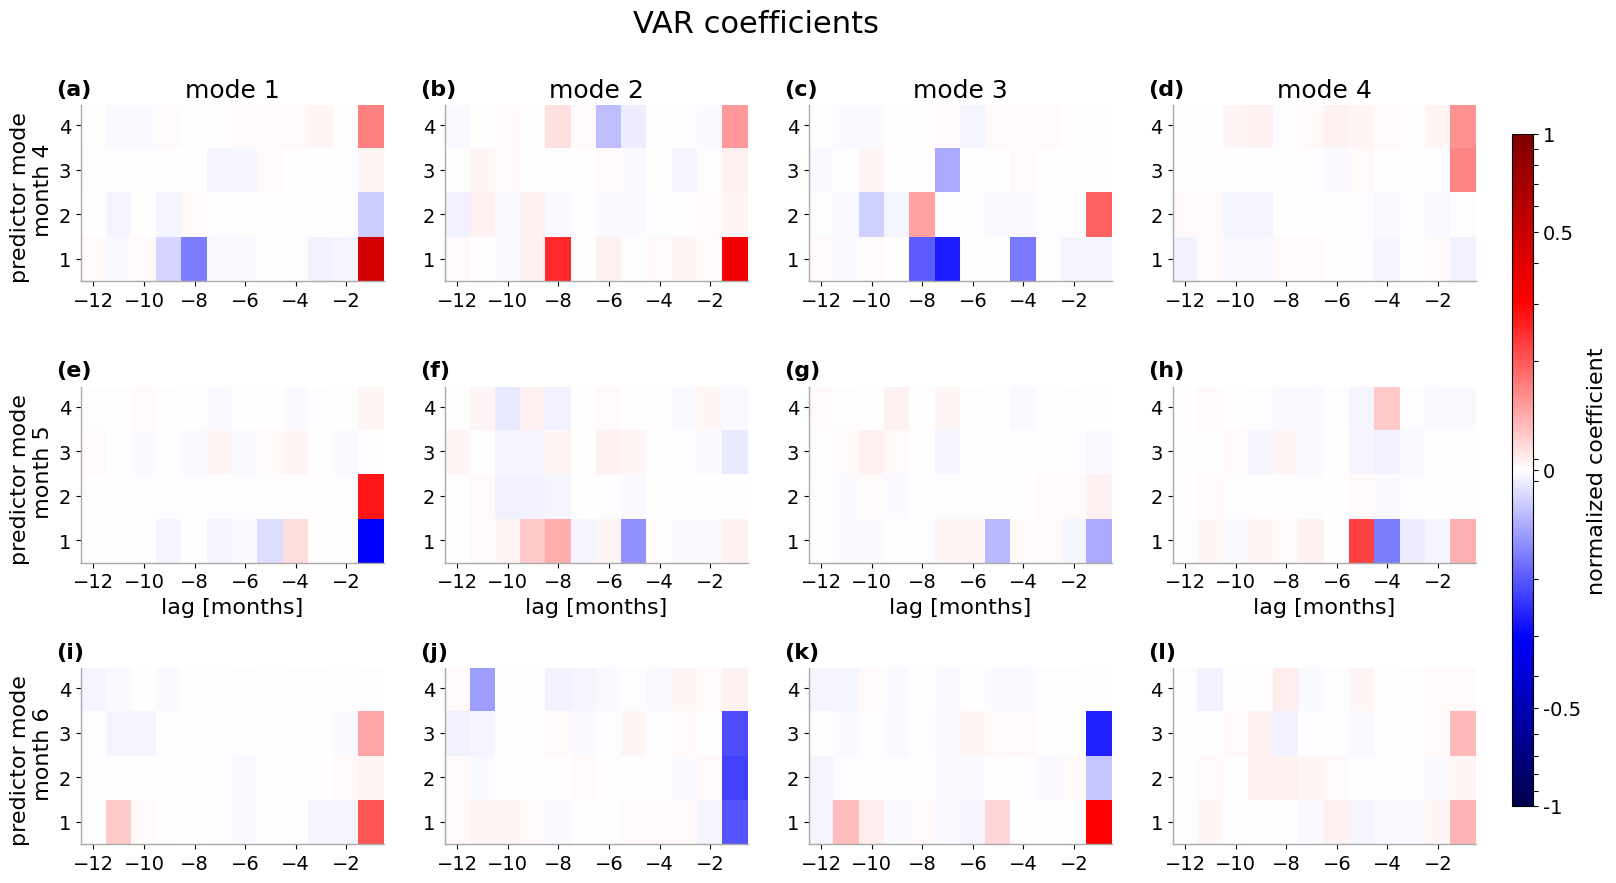

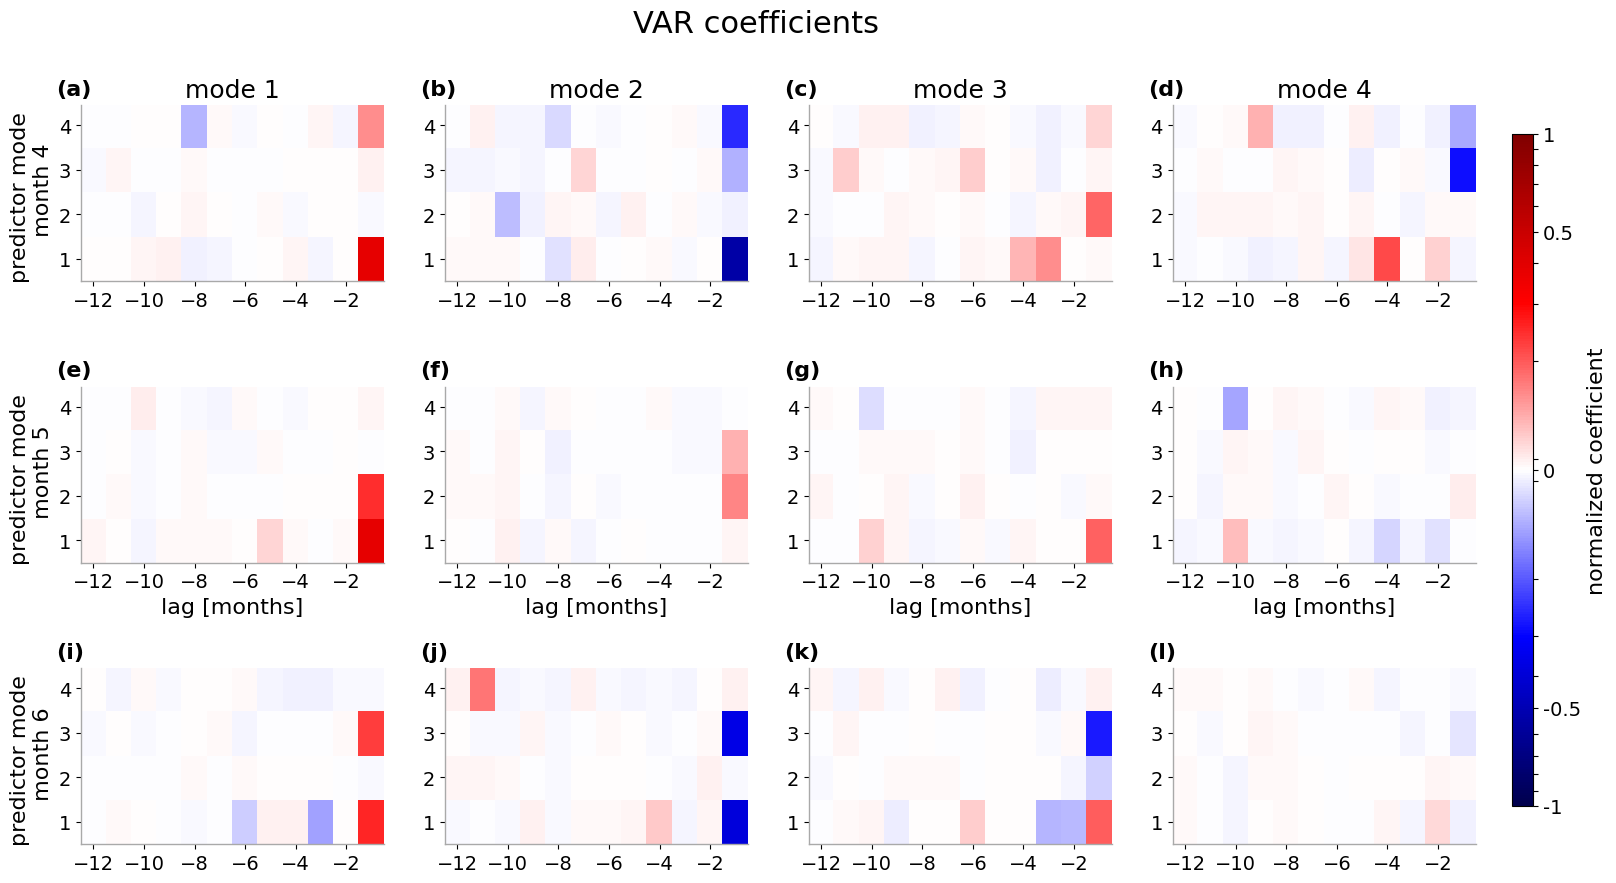

In [17]:
plot_var_coeffs(lagged_coeffs_dataset_training, name='training', months_per_row=[4,5,6])
plot_var_coeffs(lagged_coeffs_dataset_testing, name='testing', months_per_row=[4,5,6])

In [18]:
# plot_var_coeffs(lagged_coeffs_dataset_training, name='training', months_per_row=[7, 8, 9])
# plot_var_coeffs(lagged_coeffs_dataset_testing, name='testing', months_per_row=[7, 8, 9])

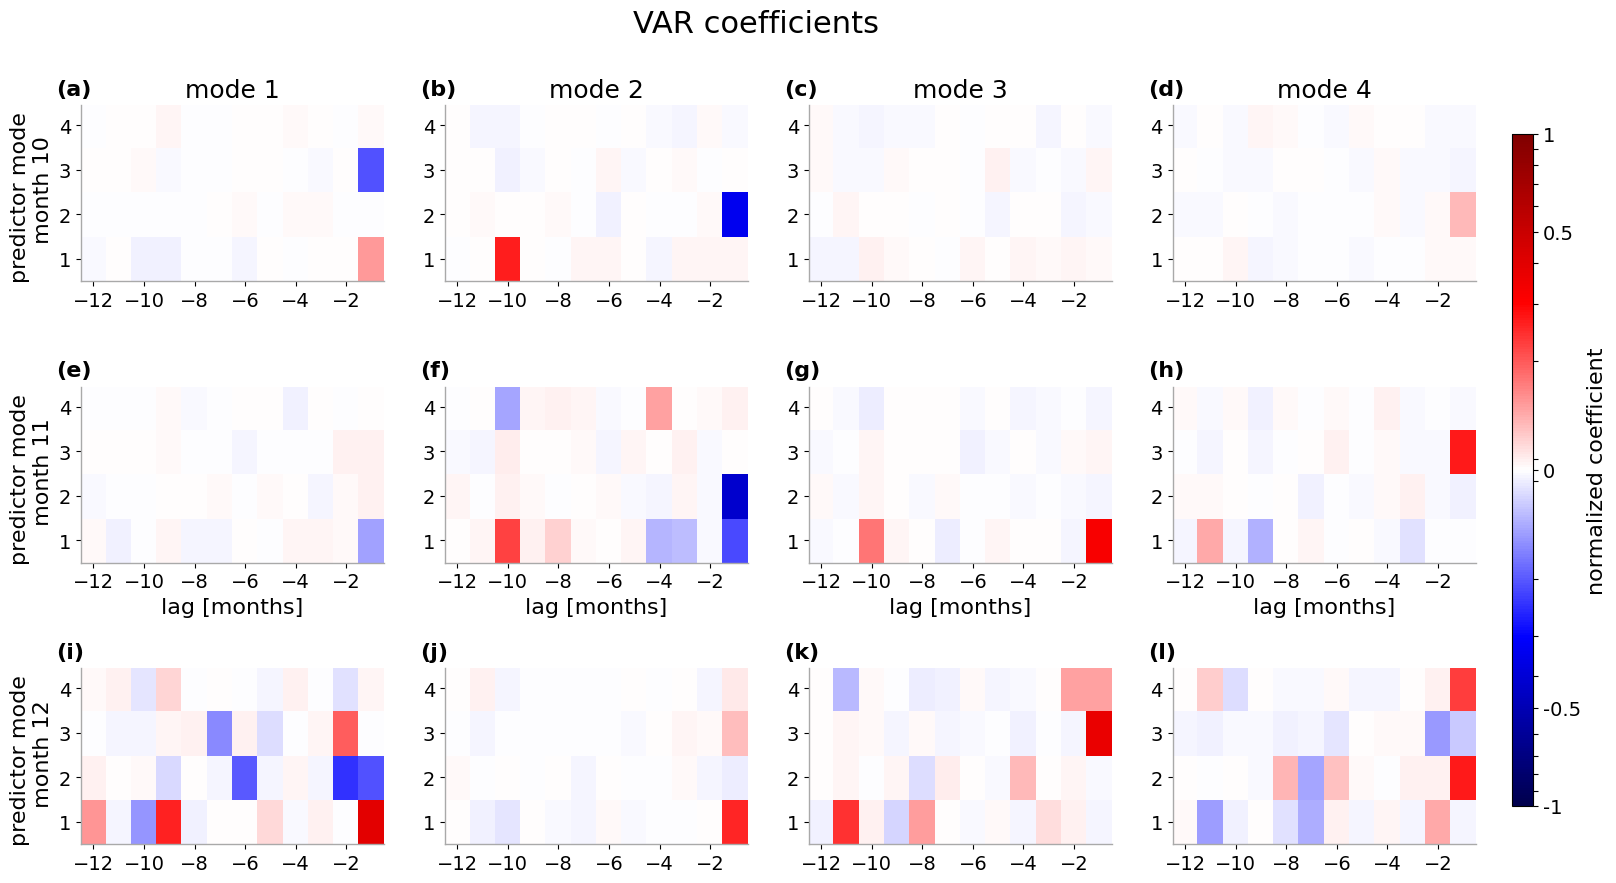

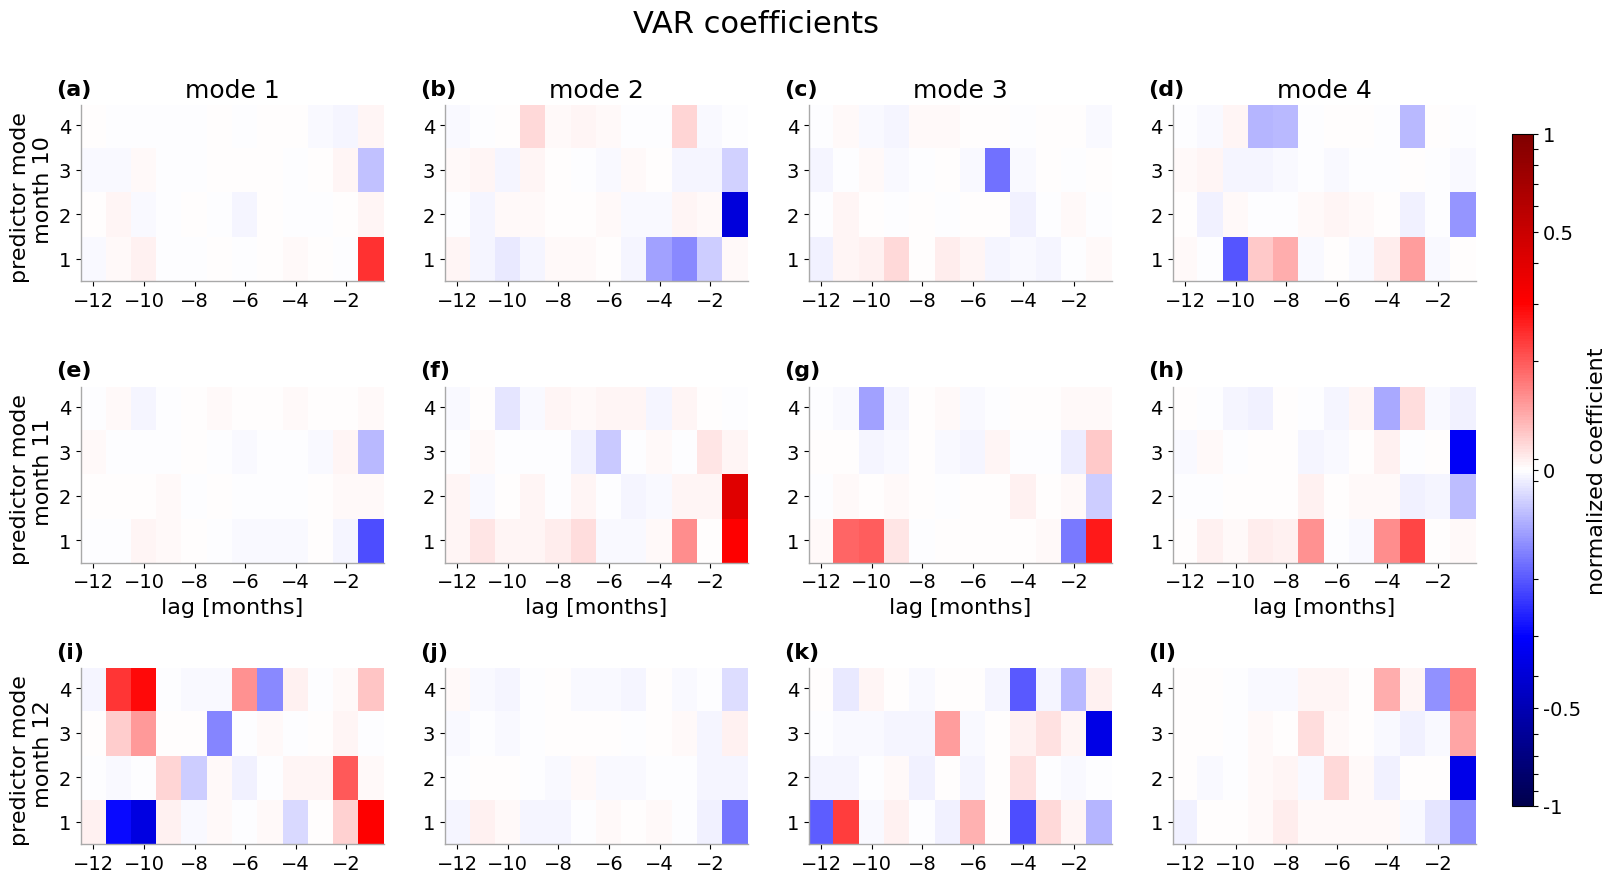

In [19]:
plot_var_coeffs(lagged_coeffs_dataset_training, name='training', months_per_row=[10, 11, 12])
plot_var_coeffs(lagged_coeffs_dataset_testing, name='testing', months_per_row=[10, 11, 12])

## Figure S14 

Global mean T anomaly comparisons (as in main text Fig. 2) for InVERT trained on separate halves of the LENS2 Historical ensemble (where InVERT1 is output from the emulator trained on 25 randomly selected members, and InVERT2 is output from the emulator trained on the other 25 members)

In [20]:
def emulate_pcs(training_pcs, monthly_var_models, n_training_members, 
                optimal_lag, n_samples, n_steps, nmodes, M, savepath, name):
    '''
    - add input arg name (str): whether the PCs are from the testing or the training half of the LENS ensemble
    '''
    lag_order = optimal_lag
    total_steps_to_generate = n_steps + lag_order + M + 12
    training_pcs_values = training_pcs.pcs.values
    training_months_values = training_pcs.month.values
    len_pcs = len(training_pcs.time)
    valid_start_indices = np.arange(len_pcs - lag_order)

    len_training_member = len(training_pcs.time) // n_training_members 
    indices_btwn_ens_members = [len_training_member * i for i in range(1, n_training_members)]
    forbidden_indices = []
    for idx in indices_btwn_ens_members:
        for i in range(-lag_order + 1, 1): 
            forbidden_indices.append(idx + i)
    valid_start_indices = [idx for idx in valid_start_indices if idx not in forbidden_indices]
    
    emulated_samples = []
    for i in range(n_samples):

        start_index = np.random.choice(valid_start_indices)
        initial_conditions = training_pcs_values[start_index : \
                                                 start_index + lag_order, :]
        synthetic_series = [initial_conditions[j, :] for j in range(lag_order)]
        last_initial_condition_month_index = start_index + lag_order - 1
        current_month = training_months_values[last_initial_condition_month_index] 
        for step in range(total_steps_to_generate - lag_order):
            
            month_to_predict = (current_month % 12) + 1
            model_components = monthly_var_models[month_to_predict]
            intercept = model_components['intercept']
            lagged_coeffs = model_components['lagged_coeffs'] # Shape: (lag, input_mode, output_mode)
            residuals = model_components['residuals'] # Shape: ( (len(training_pcs) // 12 -1), nmodes )

            input_features = np.array(synthetic_series[-lag_order:]) # Shape: (lag, mode)
            input_features_flat = input_features.flatten() # Shape: (lag * mode,)
            input_features_with_intercept = np.hstack([np.ones(1), input_features_flat]) 
            lagged_coeffs_reshaped = lagged_coeffs.reshape((lag_order * nmodes, nmodes))
            predicted_pcs = intercept + np.dot(input_features_flat, 
                                               lagged_coeffs_reshaped) 

            random_residual_index = np.random.choice(residuals.shape[0])
            sampled_residual = residuals[random_residual_index, :]
            predicted_pcs_with_residual = predicted_pcs + sampled_residual
            synthetic_series.append(predicted_pcs_with_residual)
            current_month = month_to_predict
        
        synthetic_series = np.array(synthetic_series) 
        start_month_generated = (training_months_values[start_index + lag_order - 1] % 12) + 1
        full_months_sequence = np.tile(np.arange(1, 13), 
                                       total_steps_to_generate // 12 + 2)[start_month_generated - \
                                       1 : start_month_generated - 1 + total_steps_to_generate - lag_order]

        initial_condition_months = training_months_values[start_index : start_index + lag_order]
        full_months_sequence = np.concatenate((initial_condition_months, full_months_sequence))

        first_january_index = -1
        for idx in range(lag_order + M, total_steps_to_generate): # Start searching after burn-in
            if full_months_sequence[idx] == 1: # January
                first_january_index = idx
                break
        if first_january_index != -1: 
            truncated_sample = synthetic_series[first_january_index : first_january_index + n_steps, :]
            months = full_months_sequence[first_january_index : first_january_index + n_steps]
        else:
            print("Warning: Could not find a January after burn-in. Truncating from the end.")
            truncated_sampled = synthetic_series[-n_steps:, :]
            months = np.tile(np.arange(1, 13), n_steps // 12 + 1)[-n_steps:] # Assign repeating months
            
        emulated_samples.append(truncated_sample)

    emulated_samples = np.array(emulated_samples)   
    months = np.array(months) # Assuming all truncated samples have the same month sequence
    emulated_da = xr.DataArray(emulated_samples,
                               dims=("ensemble", "time", "mode"),
                               coords={"ensemble": np.arange(n_samples),
                                        "time": np.arange(n_steps),
                                        "mode": np.arange(nmodes)})
    emulated_da = emulated_da.assign_coords({'month': ('time', months)})
    new_pcs_final = emulated_da.to_dataset(name='pcs')
    new_pcs_final = new_pcs_final.assign_coords({'month': ('time', months)})
    new_pcs_final.to_netcdf(savepath + 'InVERT_PCs_'+name+'_monthly_VAR.nc')
    return new_pcs_final

In [21]:
n_training_members = 25

InVERT_pcs_training = emulate_pcs(training_pcs, monthly_var_models_training, n_training_members,
                                  optimal_lag, n_samples, n_steps, nmodes, M, savepath, name='training')

InVERT_pcs_testing = emulate_pcs(testing_pcs, monthly_var_models_testing, n_training_members,
                                 optimal_lag, n_samples, n_steps, nmodes, M, savepath, name='testing')

In [22]:
## Separate PCs back into separate months, multiply by EOFs independently, and re-merge sorted by time
## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.

print('Multiplying PCs * EOFs and dividing by weights')
products_by_month_training = {}
products_by_month_testing = {}
for month in range(1, 13): 
    print(month)
    products_by_month_training[month] = InVERT_pcs_training.groupby('month')[month] * \
                                        training_eofs_dict[month]['eofs'] / weights
    products_by_month_testing[month] = InVERT_pcs_testing.groupby('month')[month] * \
                                       testing_eofs_dict[month]['eofs'] / weights
    
## Sum T anomalies over modes then merge
print('Summing over modes')
products_by_month_summed_training = {}
products_by_month_summed_testing = {}
for month in range(1, 13): 
    print(month)
    products_by_month_summed_training[month] =  products_by_month_training[month].pcs.sum(dim='mode')
    products_by_month_summed_testing[month] =  products_by_month_testing[month].pcs.sum(dim='mode')
    
## Re-stack ensemble members over time (for easier re-sorting of months by time) and save in new dict
print('Stacking ensemble members over time')
Tanoms_bymonth_training = {}; Tanoms_bymonth_testing = {}
for month in range(1, 13): 
    print(month)
    Tanoms_bymonth_training[month] = (stack_time(products_by_month_summed_training[month]))
    Tanoms_bymonth_testing[month] = (stack_time(products_by_month_summed_testing[month]))
    
## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
## back together in time order (e.g. month 1 year 1, month 2 year 1, ... month 12 year 1, 
## month 1 year 2, month 2 year 2, ... etc)
print('Updating time indices')
Tanom_da_list_training = []; Tanom_da_list_testing = []
for month in range(1, 13): 
    print(month)
    Tanoms_month_training = Tanoms_bymonth_training[month]
    Tanoms_month_training['time'] = Tanoms_month_training.time * 12 + month - 1
    Tanoms_month_training = Tanoms_month_training.to_dataset(name='T')
    Tanom_da_list_training.append(Tanoms_month_training)
    
    Tanoms_month_testing = Tanoms_bymonth_testing[month]
    Tanoms_month_testing['time'] = Tanoms_month_testing.time * 12 + month - 1
    Tanoms_month_testing = Tanoms_month_testing.to_dataset(name='T')
    Tanom_da_list_testing.append(Tanoms_month_testing)
    
## Concatenate over time dimension and sort by time 
print('Merging and sorting by time')
InVERT_stacked_training = xr.concat(Tanom_da_list_training, dim='time').sortby('time')
InVERT_stacked_training['gmean'] = areaweighted_mean(InVERT_stacked_training.T)

InVERT_stacked_testing = xr.concat(Tanom_da_list_testing, dim='time').sortby('time')
InVERT_stacked_testing['gmean'] = areaweighted_mean(InVERT_stacked_testing.T)

InVERT_training = unstack_time(InVERT_stacked_training, esize=n_samples)
InVERT_testing = unstack_time(InVERT_stacked_testing, esize=n_samples)

print('Saving final InVERT dataset')
InVERT_training.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_training.nc')
InVERT_testing.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_testing.nc')
print('saved')

Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
1
2
3
4
5
6
7
8
9
10
11
12
Merging and sorting by time
Saving final InVERT dataset
saved


In [23]:
InVERT_training = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+ 'modes_training.nc')

InVERT_testing = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+ 'modes_testing.nc')

In [25]:
## Concatenate emulated ensemble members in time
InVERT_training_stacked = stack_time(InVERT_training) 
InVERT_testing_stacked = stack_time(InVERT_testing) 

## Figure S14

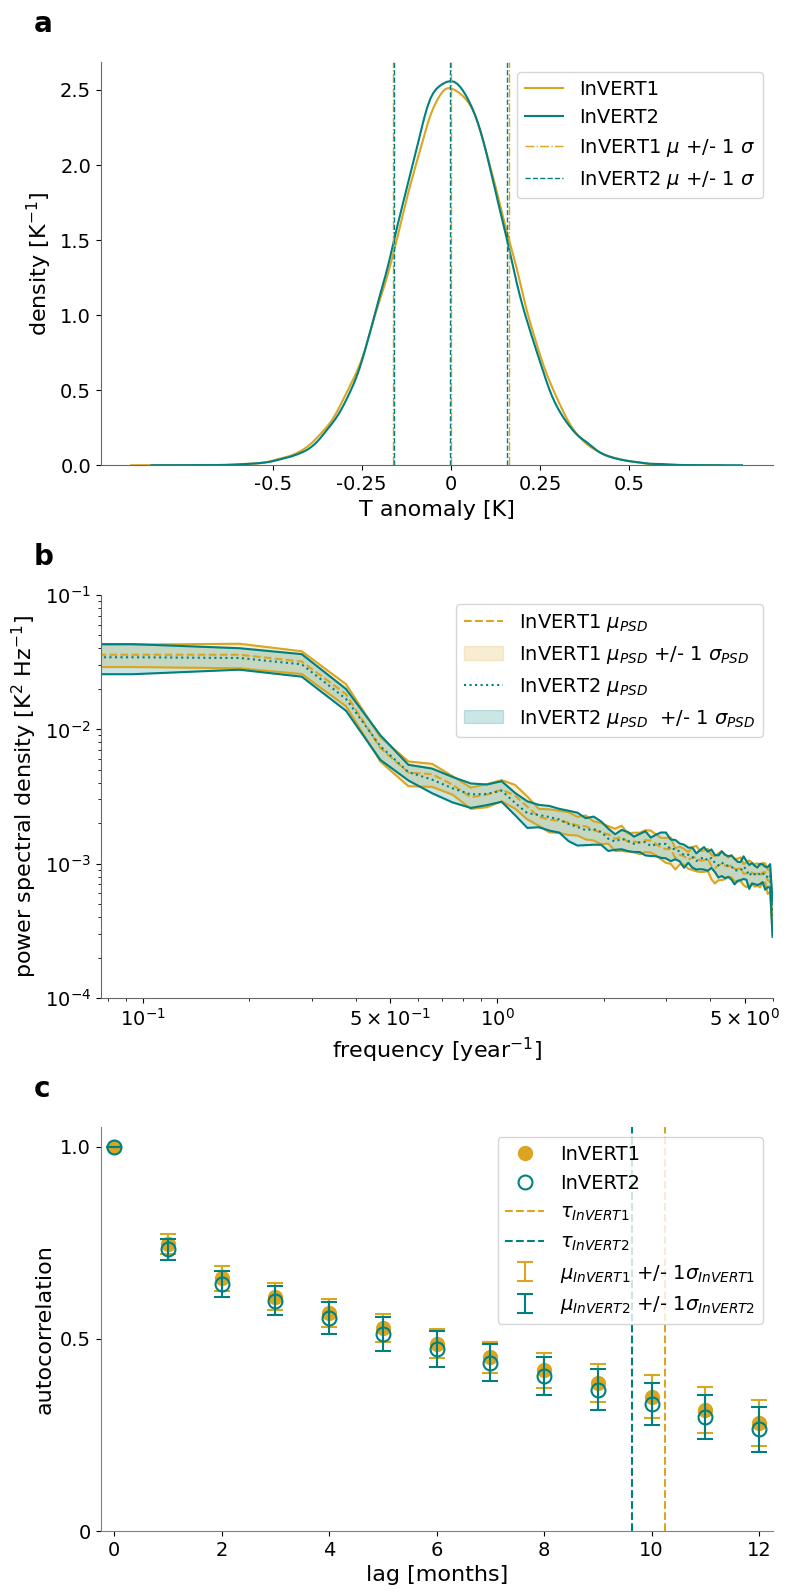

In [26]:
titlefontsize=20
plot_GMST_comparisons(InVERT_training, InVERT_testing, 
                      InVERT_training_stacked, InVERT_testing_stacked,
                      'InVERT1', 'InVERT2', color1, color2, savepath, 
                      save_name = 'Figure_S14_GMST_testing_vs_training')

In [27]:
## save regional mean data

# # Testing data (stacked in time) 
save_region_means(InVERT_training_stacked, name='InVERT_training_'+scenario+'_stacked', 
                  path=savepath)

# # Emulated data (stacked in time)
save_region_means(InVERT_testing_stacked, name='InVERT_testing_'+scenario+'_stacked', path=savepath)

# # Testing data unstacked 
save_region_means(InVERT_training, name='InVERT_training_'+scenario, 
                  path=savepath)

# # Emulated data (not stacked in time)
save_region_means(InVERT_testing, name='InVERT_testing_'+scenario, path=savepath)

In [28]:
# # Load regional mean data 

### Single time series 
InVERT_training_regional_stacked = xr.open_dataset(savepath + \
            'InVERT_training_'+scenario + '_stacked_AR6_region_mean_Tanoms.nc')
InVERT_testing_regional_stacked = xr.open_dataset(savepath + \
                               'InVERT_testing_'+scenario+'_stacked' + '_AR6_region_mean_Tanoms.nc')

In [29]:
### By ensemble member
InVERT_training_regional = xr.open_dataset(savepath + \
                                'InVERT_training_' + scenario + '_AR6_region_mean_Tanoms.nc')
InVERT_testing_regional = xr.open_dataset(savepath + \
                        'InVERT_testing_'+scenario+'_AR6_region_mean_Tanoms.nc')

In [30]:
# ## Calculate gridcell standard deviations of T anomaly data separated into ensemble members

## Calculate std of T anomalies for InVERT1 and InVERT2
std_invert_training = InVERT_training.T.std('time') 
std_invert_testing = InVERT_testing.T.std('time')

## Save gridcell T anomaly standard deviations
std_invert_training.to_netcdf(savepath + 'std_invert_training.nc')
std_invert_testing.to_netcdf(savepath + 'std_invert_testing.nc'); 

In [31]:
## Compute ensemble mean standard deviations at each gridcell
emean_std_invert_training = std_invert_training.mean('ensemble')
emean_std_invert_testing = std_invert_testing.mean('ensemble')

In [32]:
## Compute gridcell PSD
InVERT_training_grid_psd = calc_gridcell_psd(InVERT_training.T)
InVERT_testing_grid_psd = calc_gridcell_psd(InVERT_testing.T)

In [33]:
## Compute ensemble mean MSE of PSDs at each gridcell
grid_emean_mse = calc_emean_gridcell_MSE(InVERT_training_grid_psd, 
                                         InVERT_testing_grid_psd)

In [34]:
### Calculate e-folding times of T anomalies at every gridcell and save
print('calculating gridcell e-folding times (training ensemble)')
InVERT_training_gridcell_tau = calc_efold_time_dataset(InVERT_training.T)

calculating gridcell e-folding times (training ensemble)


In [35]:
print('calculating gridcell e-folding times (testing ensemble)')
InVERT_testing_gridcell_tau = calc_efold_time_dataset(InVERT_testing.T)

calculating gridcell e-folding times (testing ensemble)


In [36]:
efts_training = InVERT_training_gridcell_tau
efts_testing = InVERT_testing_gridcell_tau

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

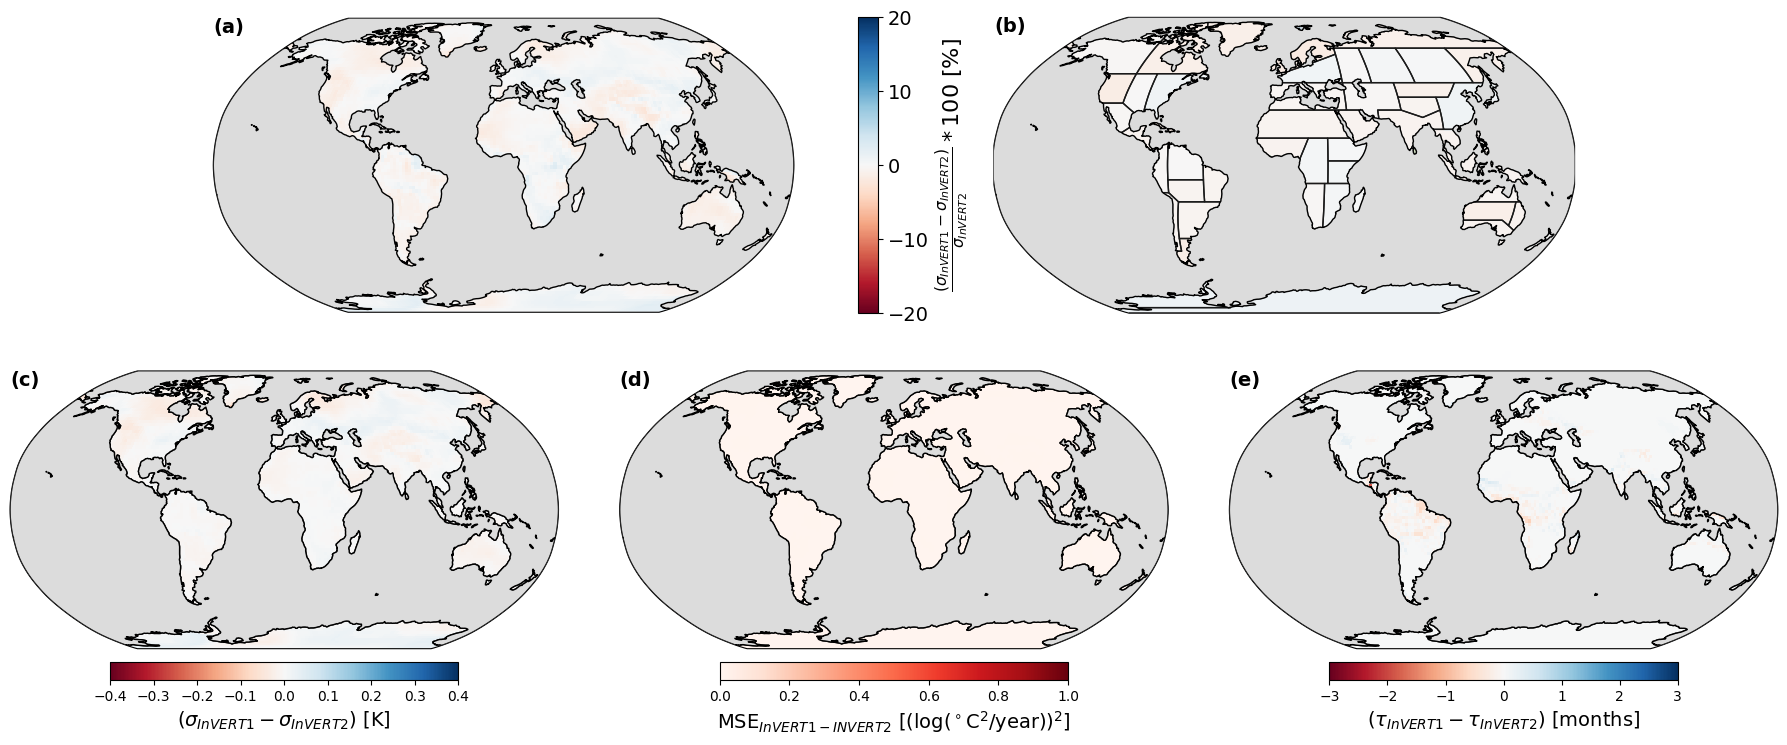

In [37]:
## Data for map plots
shrink = 0.78
vmin_pct_std, vmax_pct_std, img, ds1 = plot_gridcell_diff(D1=emean_std_invert_training, 
                                                          D2=emean_std_invert_testing,
                                            stat='standard deviation', difference='percent',
                                            ax=None, fig=None, shrink = shrink, colorbar=False);
plt.clf();
ds2 = plot_regional_diff_map(InVERT_training_regional, InVERT_testing_regional, ds_gridded=InVERT_training,
                               difference='percent', stat='std', vmin=0, vmax = 30, # vmin_pct_std, 
                               # vmax=vmax_pct_std, 
                               ax=None, fig=None, shrink=shrink,
                               colorbar=False); plt.clf();
vmin_pct_std, vmax_pct_std, img, ds3 = plot_gridcell_diff(D1=emean_std_invert_training,
                                                          D2=emean_std_invert_testing,
                                                stat='standard deviation', difference='absolute',
                                                ax=None, fig=None, shrink = shrink, colorbar=True,
                                                find_vlims=False, vmin=-0.6, vmax=0.6);  plt.clf();
ds4 = grid_emean_mse
ds5 = efts_training.mean('ensemble') - efts_testing.mean('ensemble')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8),
                         subplot_kw={'projection': ccrs.Robinson()})
fig.delaxes(axes[0, 2])  
ax = axes[0,0]
im1 = ax.pcolormesh(ds1['lon'], ds1['lat'], ds1.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-20, vmax=20) 
ax.stock_img()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')
ax = axes[0, 1]
im2 = axes[0, 1].pcolormesh(ds2['lon'], ds2['lat'], ds2.values, transform=ccrs.PlateCarree(),
                            cmap='RdBu', vmin=-20, vmax=20)
ax.stock_img()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')

regions = regionmask.defined_regions.ar6.land
# Plot AR6 region boundaries with custom edgecolor and linewidth
regions.plot(ax=ax,add_ocean=True,
             ocean_kws={'facecolor': 'lightgray'},
             label='number', text_kws={'visible':False},
             line_kws={'lw':1}) # linewidth of region boundaries
ax = axes[1,0]
im3 = ax.pcolormesh(ds3['lon'], ds3['lat'], ds3.values, transform=ccrs.PlateCarree(),
                    cmap='RdBu', vmin=-0.4, vmax=0.4)
ax.stock_img()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')
ax = axes[1,1]
im4 = ax.pcolormesh(ds4['lon'], ds4['lat'], ds4.values, transform=ccrs.PlateCarree(),
                    cmap='Reds', vmin=0, vmax=1)
ax.stock_img()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')
ax = axes[1,2]
im5 = ax.pcolormesh(ds5['lon'], ds5['lat'], ds5.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-3, vmax=3)
ax.stock_img()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                    wspace=0.05, hspace=0.1) # Reduce  spacing between subplots                      
# Increase horizontal space between top two subplots AND center them in the top row
extra_space = 0.1  # Adjust this value to control the extra space
# Get the original positions of both top subplots
pos1 = axes[0, 0].get_position(); pos2 = axes[0, 1].get_position()
# Calculate the total width of the two subplots plus the extra space
total_width = pos1.width + pos2.width + extra_space
# Calculate the starting position to center the subplots
start_position = (1 - total_width) / 2  # 1 represents the total figure width
# Shift the left subplot to the calculated starting position
axes[0, 0].set_position([start_position, pos1.y0, pos1.width, pos1.height])
# Shift the right subplot to the right of the left subplot with extra space
axes[0, 1].set_position([start_position + pos1.width + extra_space, pos2.y0, pos2.width, pos2.height])

left_edge = axes[0, 0].get_position().x1
right_edge = axes[0, 1].get_position().x0
center_position = (left_edge + right_edge) / 2

cbar_ax = fig.add_axes([center_position - 0.018,  # Adjust position with padding as needed
                        axes[0, 1].get_position().y0, 0.01,
                        axes[0, 1].get_position().height])
fig.colorbar(im1, cax=cbar_ax, orientation='vertical', label='Shared Colorbar Label')

axes[0, 0].text(0.00, 1.00, '(a)', transform=axes[0, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[0, 1].text(0.00, 1.00, '(b)', transform=axes[0, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 0].text(0.00, 1.00, '(c)', transform=axes[1, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 1].text(0.00, 1.00, '(d)', transform=axes[1, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 2].text(0.00, 1.00, '(e)', transform=axes[1, 2].transAxes, fontsize=14, fontweight='bold', va='top')

cb_vert = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', label='Shared Colorbar Label')
cb_vert.ax.tick_params(labelsize=14)

for ax in axes[1,:]: # get axes for colorbars in the bottom row
    if ax == axes[1,0]:
        cb = plt.colorbar(im3, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label=r'($\sigma_{InVERT1}-\sigma_{InVERT2}$) [K]', size=14)  # Set colorbar label font size
    if ax == axes[1,1]:
        cb = plt.colorbar(im4, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label='MSE$_{InVERT1 - INVERT2}$ [(log($^\circ$C$^{2}$/year))$^{2}$]', size=14)  # Set colorbar label font size
    if ax == axes[1,2]:
        cb = plt.colorbar(im5, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04,)
        cb.set_label(label=r'$(\tau_{InVERT1} - \tau_{InVERT2})$ [months]', size=14)  # Set colorbar label font size
    ax.stock_img()
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')

cb_vert.set_label(label=r'$\frac{(\sigma_{InVERT1}-\sigma_{InVERT2})}{\sigma_{InVERT2}}*100$ [%]', 
                  size=16)
plt.show()
fig.savefig(savepath + 'Figure_S15_regional_subplots_InVERT1_vs_InVERT2.pdf'); 
fig.savefig(savepath + 'Figure_S15_regional_subplots_InVERT1_vs_InVERT2.png'); 

### Figure S16 local monthly std performance comparison (InVERT1 vs InVERT2)

In [38]:
InVERT_training_converted_lon = convert_lon(InVERT_training, 'lon')
InVERT_testing_converted_lon = convert_lon(InVERT_testing, 'lon')

In [39]:
## Calculate ensemble mean standard deviations of T anomalies by month
training_emean_monthly_stds = InVERT_training_converted_lon.T.groupby('month').std('time').mean('ensemble')
testing_emean_monthly_stds = InVERT_testing_converted_lon.T.groupby('month').std('time').mean('ensemble')

In [40]:
training_estd_monthly_stds = InVERT_training_converted_lon.T.groupby('month').std('time').std('ensemble')
testing_estd_monthly_stds = InVERT_testing_converted_lon.T.groupby('month').std('time').std('ensemble')

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


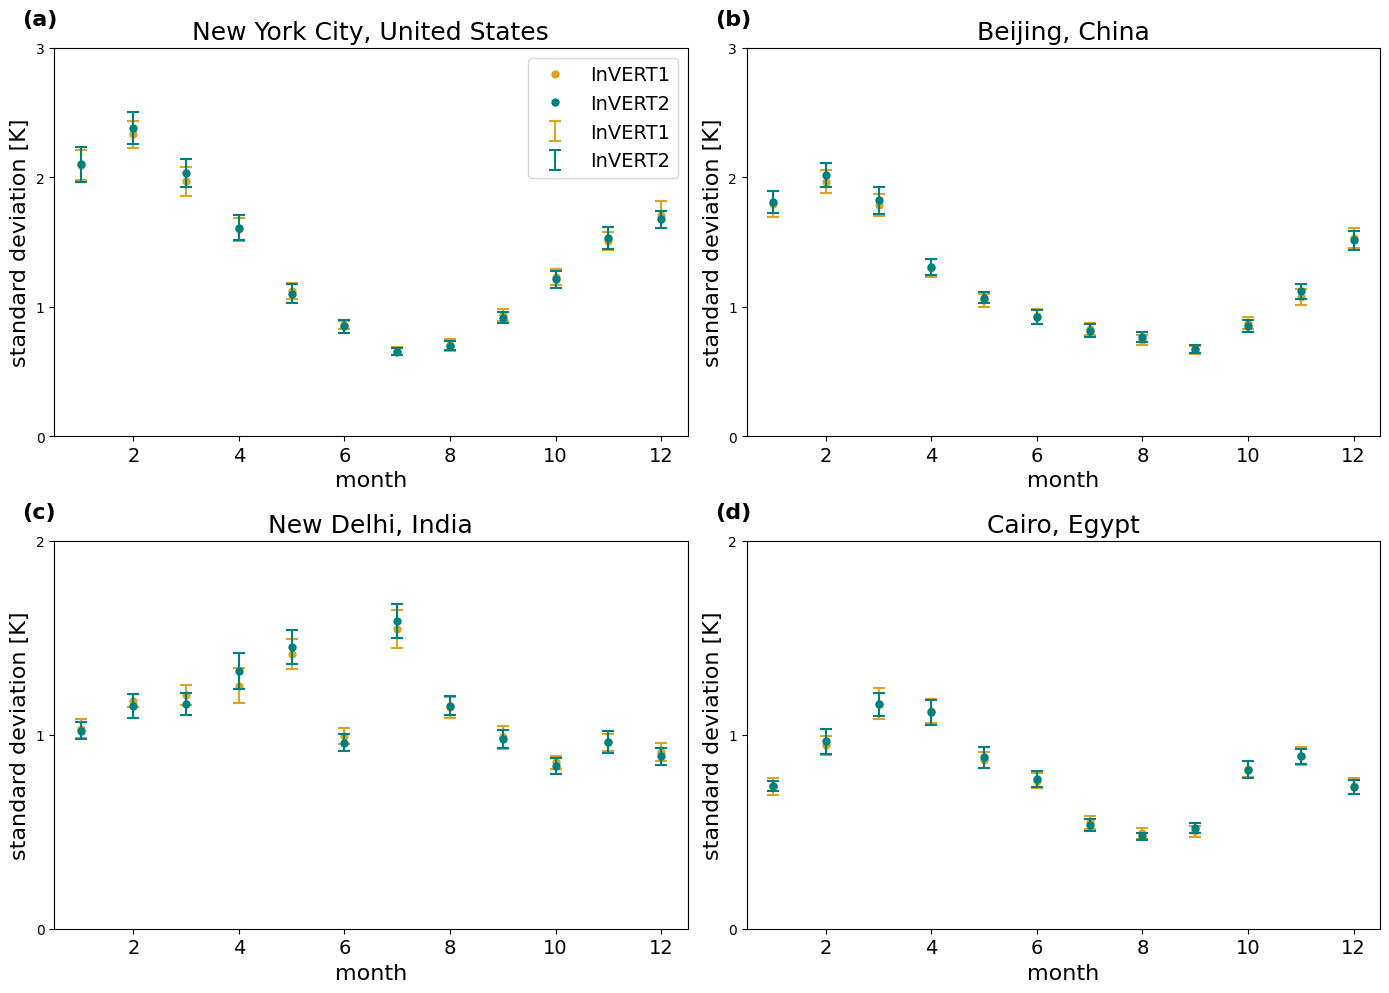

In [41]:
locations_lat_lon = [(40.7, -74, 'New York City, United States'),
                     (39.9, 116.4, 'Beijing, China'),
                     (28.7, 77.2, 'New Delhi, India'),
                     (30.05, 31.23, 'Cairo, Egypt' )]

plot_local_monthly_T_stds(training_emean_monthly_stds, testing_emean_monthly_stds,
                          training_estd_monthly_stds, testing_estd_monthly_stds,
                          locations_lat_lon, savepath, ylim=[3,3,2,2], 
                          save_name = 'Figure_S16_monthly_stds_testing_vs_training_halves',
                          name1='InVERT1', name2='InVERT2')